# Tutorial: Using the SpinChain class

In [33]:
# generic import statements
import numpy as np
from scipy.sparse import linalg as slinalg
from matplotlib import pyplot as plt
# import tensor product function, SpinChain class
from SpinChain import tp, SpinChain 

## Initializing a Spin Chain

First, we can initialize an empty spin chain by setting the spin, length, and boundary conditions. In this example, we initialize a chain of length `L` $=8$ with sites that contain a `spin` $=1/2$ degree of freedom. For now, we take open boundary conditions by setting `bc` to zero, but could consider periodic or antiperiodic boundary conditions with $\pm 1$.

In [34]:
chain = SpinChain(spin=1/2, L=8, bc=0) # initialize system with spin 1/2
chain_pbc = SpinChain(spin=1/2, L=8, bc=1) # periodic version of same chain
# print type and attributes
print(type(chain))
print(f'L = {chain.L}, spin = {chain.spin}, bc = {chain.bc}')

<class 'SpinChain.SpinChain'>
L = 8, spin = 0.5, bc = 0j


We also have access to the local spin operators as an attribute: `SpinChain.spin_mat_list`. In order, this returns the identity $\mathbb{1}$, the spin-z operator $S^z$, and the raising and lowering operators $S^+$ and $S^-$. A more flexible way to get local (spin) operators is to use the `SpinChain.getPauli()` method. Depending on its optional argument, this method returns the lists $\{\mathbb{1}, S^z, S^+, S^-\}$ (`basis = pm`, default), $\{\mathbb{1}, S^x, S^y, S^z\}$   (`basis = xyz`), the $2 \times 2$ Pauli matrices $\{\mathbb{1}, \sigma^x, \sigma^y, \sigma^z\}$ (`basis = pauli`), or their qudit generalization to clock and shift matrices $\{\mathbb{1}, Z, X\}$ (`basis = clock_shift`).

In [35]:
# Note that these are true spin operators (for spin-1/2 they are 1/2 of Pauli matrices)
s0, sz, sp, sm = chain.getPauli()
print(f'Sz = {sz}')
print(f'S+ = {sp}')
print(12*"*")

# exact 2x2 spin-1/2 Pauli matrics
sigma0, sigmax, sigmay, sigmaz = chain.getPauli('pauli')
print(f'\u03C3z = {sigmaz}')
print(f'\u03C3x = {sigmax}')
print(12*"*")

# Show clock and shift operators for qutrit (spin-1 -> 3-site Hilbert space)
Id, Z, X = SpinChain(spin=1, L=1, bc=0).getPauli('clock_shift')
print(f'X = {X}')

Sz = [[-0.5  0. ]
 [ 0.   0.5]]
S+ = [[0. 1.]
 [0. 0.]]
************
σz = [[ 1  0]
 [ 0 -1]]
σx = [[0 1]
 [1 0]]
************
X = [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


## Initializing a Hamiltonian

We can now make our system more interesting by including local Hamiltonian terms that define the interactions in the spin chain. This is implemented as tensor products of local operators acting on a list of sites. For periodically repeating terms, one must specify a *list of local site lists* at which to apply the operators. Such local site lists should be written in *ascending order when they do not wrap around the boundary* of the chain: terms that *do* wrap around the chain are ignored for open boundary conditions.

Here, we consider a free fermion Hamiltonian with nearest-neighbor hopping in OBC, which by the [Jordan-Wigner transformation](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation) can be mapped to a nearest-neighbor spin-conserving model: $H = -t \sum_j (S^+_i S^-_{i+1} + S^-_i S^+_{i+1})$. After adding these local operators at all nearest neighbor pairs of sites, we can use `SpinChain.getHam()` to return the sparse Hamiltonian array. If needed, we can make it dense by using `numpy.ndarray.todense()`. For large systems, we can improve performance by constructing only half of the hopping terms and then calling `SpinChain.plusConj()` to automatically add the Hermitian conjugate to the Hamiltonian. 

In [36]:
t = 1
hop_left = [sp, sm] # local hopping operator
pairs = [[site, site+1] for site in range(chain.L)] # (nearest neighbor) site pairs where local operators act

# N.B. site indices are always taken mod L inside the SpinChain class
# This means that the last pairing in sites is interpreted as [7, 0] instead of [7, 8]
# The [7,0] coupling wraps around the 1D chain, and is only considered if bc != 0

chain.setHamTerm(op_list = hop_left, site_list_list = pairs, coeff = -t) # NN spin hopping
chain.plusConj() # add h.c.

# get full sparse Hamiltonian
H = chain.getHam()
print(type(H))
print(H.shape)

<class 'scipy.sparse._arrays.bsr_array'>
(256, 256)


## Exact diagonalization

We are finally ready to actually perform the exact diagonalization. If the system is not too big ($L \lesssim 10$), the spectrum and states of the Hamiltonian can be found exactly without sparse matrix methods. Beyond that regime, we must use symmetries to reduce the size of the Hilbert space, or resort to sparse matrix methods to find a few eigenvalues/vectors. In particular, we can reduce the size of the Hilbert space drastically by working in a fixed charge (particle number) symmetry sector.

In [37]:
# diagonalize the full 10-site spin chain
print('Full Hilbert space dimension:', chain.getHilbertDim())
vals, vecs = np.linalg.eigh(H.toarray())
print(vals.shape)
print(20*'*')

# only find the lowest four energies and states using sparse matrix techniques (Lanczos)
vals_sparse, vecs_sparse = slinalg.eigsh(H, k=4, which='SA', return_eigenvectors=True)
print('Eigvals exact:', vals[:4])
print('Eigvals sparse:', np.sort(vals_sparse[:4])) # eigvals match the full calculation above
print(20*'*')

# project the Hamiltonian into the Magnetization = 0 sector (e.g. fixing particle number at half-filling)
# diagonalize only this projected block
chain.projectHam(M=0)
H_projected = chain.getHam()
print('Hilbert space dimension with M=0 fixed:', chain.getHilbertDim()) # smaller Hilbert space dim
vals, vecs = np.linalg.eigh(H_projected.toarray())
print('Eigvals in sector:', vals[:4]) # the ground state happens to be in this sector
print(vals.shape)

# return to the full Hilbert space
chain.unprojectHam()

Full Hilbert space dimension: 256
(256,)
********************
Eigvals exact: [-4.75877048 -4.41147413 -4.41147413 -4.06417777]
Eigvals sparse: [-4.75877048 -4.41147413 -4.41147413 -4.06417777]
********************
Hilbert space dimension with M=0 fixed: 70
Eigvals in sector: [-4.75877048 -4.06417777 -3.41147413 -3.41147413]
(70,)


## Projecting into sectors

For any symmetry of the system, the Hamiltonian is block diagonal in some basis, where each block corresponds to a sector of the Hilbert space at fixed symmetry charge. In the example above, we used the spin-conservation of the model to restrict to the $M_z = 0$ block, reducing the size of the Hamiltonian from $256 \times 256$ to $70 \times 70$. In some spin chains with kinematic constraints, like dipole (center of mass) conservation, the Hilbert space can exhibit further fragmentation: each symmetry sector *itself* splits into several disconnected blocks. Using the method `SpinChain.getKrylov()` we can find the size of these fragmented sectors and a set of basis states for each of them. For the expert reader, we note that the code is only designed to detect fragmentation in the computational basis, which has been called *classical fragmentation*.

In [38]:
# initialize a Spin Chain with a Hamiltonian that conserves charge (spin) and its dipole moment
syst = SpinChain(spin=1/2, L=12, bc=0)
s0, sz, sp, sm = syst.getPauli()
syst.setHamTerm([sp, sm, sm, sp], [[j, j+1, j+2, j+3] for j in range(syst.L)]) # dipole hopiing
syst.plusConj() # add hermitian conjugate

print(f'Full Hilbert Dimension: {syst.getHilbertDim()}')

# project in Magnetization = Dipole = 0 symmetry sector
syst.projectHam(M=0, Pdip=0)
print(f'M = P_dipole = 0 sector dimension: {syst.getHilbertDim()}')

# this symmetry sector further splits into disconnected blocks
num_sectors, sizes, states_in_sectors = syst.getKrylov(states=True)
print(f'M = P_dipole = 0 sector splits into {num_sectors} sub-sectors of sizes:')
print(sizes)

# we now further project the Hamiltonian into the largest of these sub-sectors
states_in_largest_sector = states_in_sectors[0]
syst.unprojectHam() # return to full hilbert space before we apply a specific projector onto states_in_largest_sector
syst.projectHamSpecific(states_in_largest_sector) # project 
print(f'D_sector = {syst.getHilbertDim()}')

Full Hilbert Dimension: 4096
M = P_dipole = 0 sector dimension: 58
M = P_dipole = 0 sector splits into 23 sub-sectors of sizes:
[20  5  5  3  3  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
D_sector = 20


By exploiting the fact that the Hamiltonian breaks into smaller blocks, we have reduced the problem of diagonalizing a $4096 \times 4096$ matrix to that of diagonalizing a $20 \times 20$ matrix. This is especially useful for time dynamics: if our initial state is in a specific sub-sector of the Hilbert space, Hamiltonian time evolution will remain inside this sector, and we can effectively ignore all other blocks.

## Entanglement measures

In our closed quantum spin chains, we are (almost) always dealing with pure states, so measures of entanglement always involve the entanglement between different subsystems. The most famous such measure is the von Neumann entanglement entropy, which can be found using the method `SpinChain.getEntEntropy()`. In addition to this measure, the class includes methods to extract Rényi entropies, mutual information, and the full entanglement spectrum for any state. Here we show that for a gapped quantum spin chain, the ground state exhibits an entanglement area law, i.e., the entanglement entropy of a region does not scale with system size in 1D.

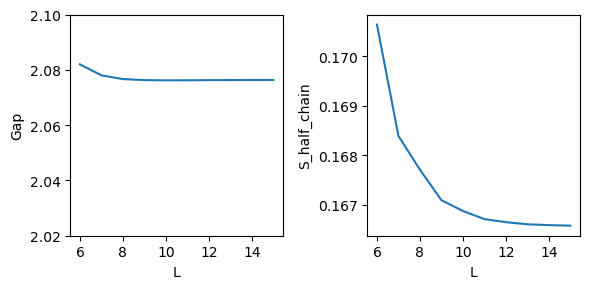

In [39]:
# Construct ground state for a tranverse + longitudinal field Ising model of length L
# work in the paramegnetic phase (gapped)
def ising_gnd(L, J=1, g=2, h=0.1):
    chain = SpinChain(spin=1/2, L=L, bc=1) # take PBC to avoid boundary effects
    I, X, Y, Z = chain.getPauli('pauli')
    chain.setHamTerm([Z, Z], [[j, j+1] for j in range(L)], coeff=-J) # ZZ term
    chain.setHamTerm([X], [[j] for j in range(L)], coeff=g) # transverse field
    chain.setHamTerm([Z], [[j] for j in range(L)], coeff=h) # longitudinal field
    
    # just get lowest two energies and states using sparse methods
    vals, vecs = slinalg.eigsh(chain.getHam(), k=2, which='SA')
    E_gnd, E_ex = vals
    psi_gnd, psi_ex = vecs.T
    
    gap = E_ex - E_gnd
    ent = chain.getEntEntropy(state=psi_gnd, region=range(0, L//2)) # entropy function requires state and sites of subsystem
    
    # return energy gap, ground state, and its half-chain entanglement entropy 
    return [gap, psi_gnd, ent]

# collect gaps and ground states for different system sizes
system_sizes = range(6, 16)
data = [ising_gnd(L) for L in system_sizes]
gaps, gnd_states, entropies = zip(*data)

# show that gap remains finite as L -> infinity
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].plot(system_sizes, gaps)
ax[0].set_ylim([2.02, 2.1])
ax[0].set_ylabel("Gap")
ax[0].set_xlabel("L")

# show that entropies don't grow extensively with system size
# this is only visible at bigger system sizes
ax[1].plot(system_sizes, entropies)
# ax[1].set_ylim([0.265, 0.275])
ax[1].set_ylabel("S_half_chain")
ax[1].set_xlabel("L")
fig.tight_layout()

plt.show()

## Time evolution

To study the hamiltonian time evolution of a quantum state, we can use the method `SpinChain.timeEvolve()`, which applies the time evolution operator to the initial state, $e^{-i H t} | \psi \rangle$. After time evolution, we can measure local expectation values or global entanglement measures in the final state. The default algorithm uses a Padé approximant technique in `scipy.sparse.linalg.expm_multiply` to directly evolve the state without constructing the unitary matrix, and is relatively stable. There are also two alternative algorithms, `timeEvolveCheb()`, which uses Chebyshev polynomials to recursively update the state, and `timeEvolveKrylov()`, which uses Krylov subspace methods to approximate time evolution. These algorithms are not as extensively tested, but they have the advantage that the user can choose their own convergence criteria, and that they can calculate time evolved expectation values *without* having to construct the final state. Here we just show a brief example of a simple initial state of all spins down $|\psi(0)\rangle = | \downarrow  \downarrow  \ldots \downarrow \rangle$ evolving under the antiferromagnetic transverse-field Ising hamiltonian.

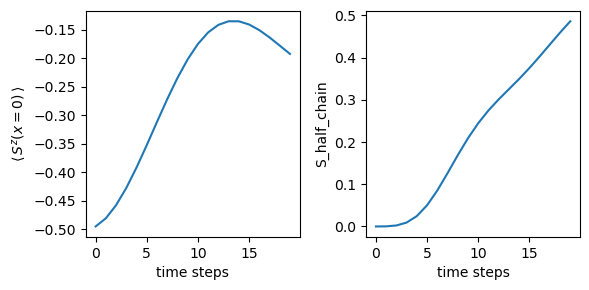

In [44]:
syst = SpinChain(spin=1/2, L=10, bc=0)
I, X, Y, Z = chain.getPauli('pauli')
syst.setHamTerm([Z, Z], [[j, j+1] for j in range(syst.L)], coeff = +1) # AF ising coupling
syst.setHamTerm([X], [[j] for j in range(syst.L)], coeff = 0.7) # small transverse field

state_init = np.zeros(syst.getHilbertDim())
state_init[0] = 1 # only nonzero coeff corresponds to |0000...00> in computational basis

# time evolve for two units of time (unit of time/energy set by J = 1 AF coupling)
# split evolution into 20 time steps, record local spin at site 0 and half-chain entanglement entropy at each step
exp_vals = []
ents = []
for step in range(20):
    state_final = syst.timeEvolve(state=state_init, time=0.1)
    
    # syntax is getExpectationValue(state, list_of_operators, list_of_sites_where_they_act)
    # Subtle: S^z (spin matrix) in my basis is diag(-1/2, 1/2) = -1/2 * Z, where Z is Pauli Z = diag(1, -1)
    exp_vals.append(syst.getExpectationValue(state_final, [-Z/2], [0])) 
    
    # syntax is getEntEntropy(state, sites_in_subsystem)
    ents.append(syst.getEntEntropy(state_final, range(0, syst.L//2)))
    
    state_init = state_final

# plot < S^z > on site 0 as a function of time
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].plot(exp_vals)
ax[0].set_ylabel(r"$\langle \, S^z (x=0) \, \rangle$")
ax[0].set_xlabel("time steps")

# show that entanglement of system grows ballistically
ax[1].plot(ents)
ax[1].set_ylabel("S_half_chain")
ax[1].set_xlabel("time steps")
fig.tight_layout()

plt.show()

Having gone through these examples, you can now mix and match the methods in the SpinChain class to study a variety of 1D interacting quantum models, both in and out of equilibrium.